In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [4]:
format_plots()
c = PlotConfig()

In [5]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [6]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [7]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

In [8]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = male_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [9]:
## clustering from win

In [10]:
norm_df = m_norm
df=male_df

In [11]:
km = KMeans(n_clusters=4, random_state=0)
lbls = km.fit_predict(norm_df.T)
syll_lbl_df = pd.DataFrame({"syll": df.columns, "lbl": lbls})

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
# sort syllables by usage within cluster
cluster_avgs = df.T.groupby(lbls).mean().T.mean().sort_values(ascending=False)
new_map_order = dict(map(reversed, enumerate(cluster_avgs.index)))
cluster_avgs

1    0.025921
2    0.016709
3    0.008622
0    0.004525
dtype: float64

In [13]:
df_with_cluster = df.T
df_with_cluster = df_with_cluster.set_index([pd.Index(lbls, name='labels').map(new_map_order), pd.Index(df_with_cluster.index, name="syllables")])

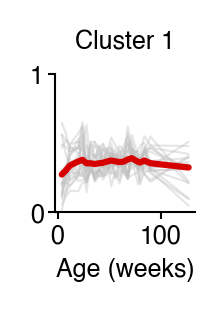

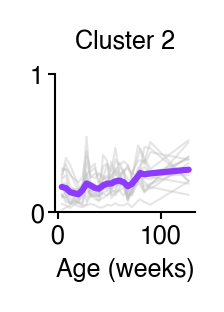

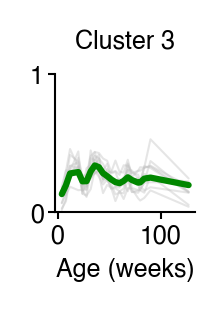

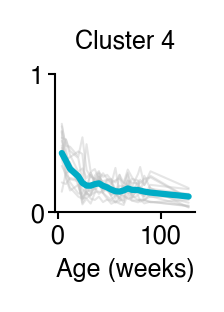

In [14]:
for _lbl, _df in norm_df.T.groupby(list(map(new_map_order.get, lbls))):
    fig = figure(0.6, 0.6)
    ax = fig.gca()
    ax = (
        _df.T.groupby("age")
        .mean()
        .plot(ax=ax, legend=False, color="silver", lw=0.5, alpha=0.4)
    )
    ax.plot(
        _df.T.groupby("age")
        .mean()
        .mean(1)
        .rolling(5, win_type="gaussian", min_periods=1, center=True)
        .mean(std=0.75),
        lw=1.5,
        color=cc.glasbey[_lbl],
    )
    ax.set(ylim=(0, 1), yticks=[0, 1], xlabel="Age (weeks)", title=f"Cluster {_lbl + 1}")
    sns.despine()
    #saver(fig, f"clustered-usage-cluster-{_lbl}")
plt.show()

In [15]:
## K-means silhouette score

In [16]:
ss_d = {}
for i in range(2, 7):
    km = KMeans(n_clusters=i, random_state=0)
    lbls = km.fit_predict(norm_df.T)
    ss = silhouette_score(norm_df.T, lbls)
    ss_d[i] = ss
ss_d

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

{2: 0.16068972038896792,
 3: 0.11831958299209852,
 4: 0.12122887657065115,
 5: 0.12529905662041313,
 6: 0.12858915530463222}

In [17]:
plt.close('all')

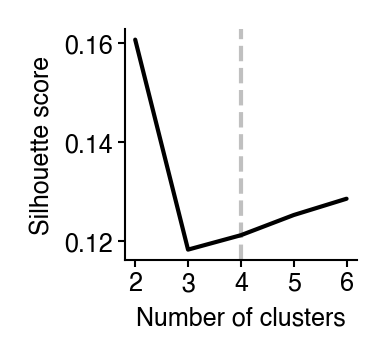

In [18]:
fig = figure(1, 1)
ax = fig.gca()
ax = pd.Series(ss_d).plot(ax=ax, color='k')
ax.set(ylabel='Silhouette score', xlabel='Number of clusters', xticks=range(2, 7))
ax.axvline(4, color='silver', zorder=-1, ls='--')
sns.despine()
fig.savefig(c.dana_save_path / "fig3"/ 'sill_clusters.pdf')

In [19]:
## my k-means

In [20]:
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0 [Index([6, 9, 10, 12, 24, 27, 41, 49, 52, 60, 73, 76, 85], dtype='int16[pyarrow]', name='syllables')]
Cluster 1 [Index([ 0,  2, 11, 17, 23, 30, 36, 42, 54, 55, 62, 63, 64, 66, 67, 69, 70, 71,
       77, 93, 95],
      dtype='int16[pyarrow]', name='syllables')]
Cluster 2 [Index([4, 5, 7, 16, 18, 25, 39, 44, 50, 53, 59, 61, 68, 74], dtype='int16[pyarrow]', name='syllables')]
Cluster 3 [Index([13, 14, 32, 33, 79, 83, 84, 90, 97, 98], dtype='int16[pyarrow]', name='syllables')]


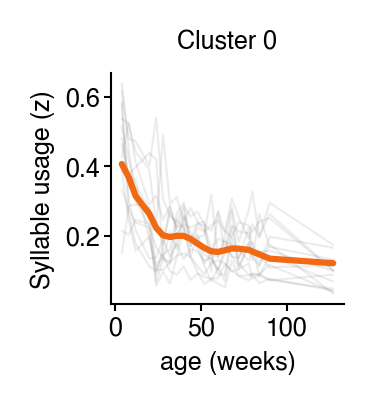

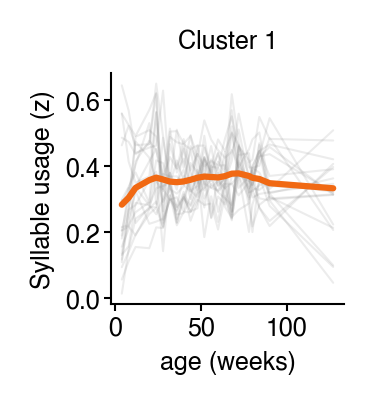

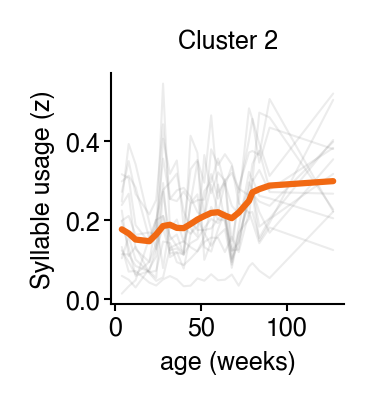

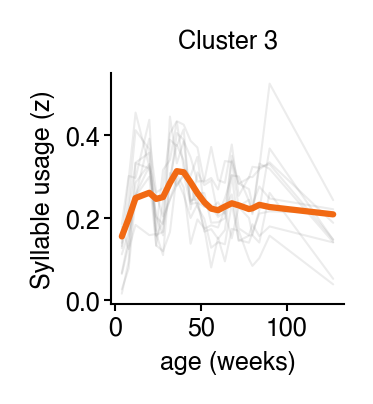

In [21]:
n_clusters = 4
sigma=1.25
sample = []
km = KMeans(n_clusters=n_clusters, random_state=0)
clusters = km.fit_predict(m_norm.T)
for i in range(n_clusters):
    fig = figure(1, 1)
    tmp = m_norm.iloc[:, clusters == i].groupby('age').mean()
    print(f'Cluster {i}', [tmp.columns])
    plt.plot(tmp, c='gray', lw=0.5, alpha=0.15,
             #linestyle='--',
            )
    csyll = [number for number in sample if number in tmp.columns]
    plt.plot(tmp[csyll], c='black', lw=0.5)
    m = tmp.mean(1)
    plt.plot(pd.Series(gaussian_filter(m, sigma=sigma), index=tmp.index), c='#f16913', lw=1.5)
    plt.title(f'Cluster {i}')
    plt.xlabel('age (weeks)')
    plt.ylabel('Syllable usage (z)')
    #plt.ylim([0,1])
    sns.despine()
    fig.savefig(c.dana_save_path / "fig3"/ f'female_cluster-{i}.pdf')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

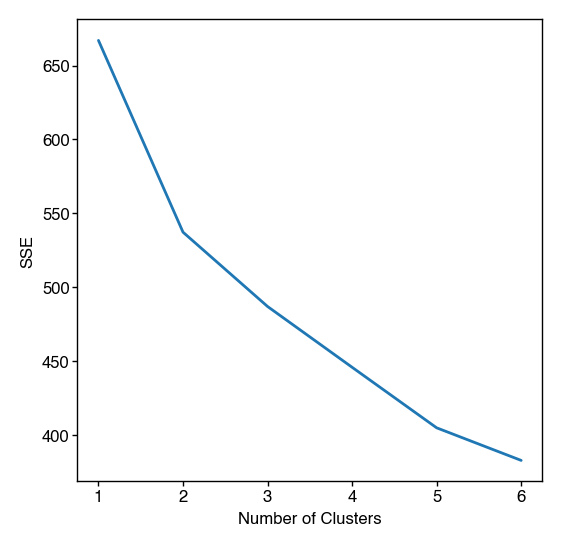

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The defa

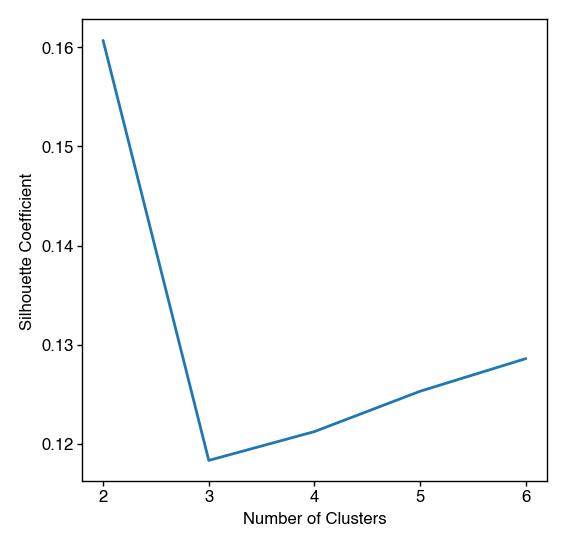

In [22]:
# A list holds the SSE values for each k
sse = []
nclust=6
for k in range(1, nclust+1):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit_predict(m_norm.T)
    sse.append(km.inertia_)

#plt.style.use("fivethirtyeight")
plt.plot(range(1, nclust+1), sse)
plt.xticks(range(1, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# figure out elbow point
#kl = KneeLocator(range(1, nclust+1), sse, curve="convex", direction="decreasing")
#print('elbow point: SSE ', kl.elbow)

# second method
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, nclust+1):
    km = KMeans(n_clusters=k, random_state=0)
    km.fit_predict(m_norm.T)
    score = silhouette_score(m_norm.T, km.labels_)
    silhouette_coefficients.append(score)

#kl = KneeLocator(range(2, nclust+1), silhouette_coefficients, curve="convex", direction="decreasing")
#print('elbow point: sill ', kl.elbow)

#plt.style.use("seaborn")
plt.plot(range(2, nclust+1), silhouette_coefficients)
plt.xticks(range(2, nclust+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()